# 1. Imports

In [1]:
import math
import json
import pickle
import random
import requests
import datetime
import inflection

import pandas              as pd
import numpy               as np
import seaborn             as sns
import xgboost             as xgb

from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from flask                 import Flask, request, Response
from boruta                import BorutaPy
from tabulate              import tabulate
from IPython.display       import Image
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

# 2. Helper Functions

In [3]:
def cramer_v(x, y):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1) * (r-1) / (n-1) )
    kcorr = k - (k-1)**2 / (n-1) 
    rcorr = r - (r-1)**2 / (n-1) 

    return float(np.sqrt( (chi2corr/n) / ( min( kcorr - 1, rcorr - 1 ) ) ))


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = root_mean_squared_error(y, yhat)

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          "RMSE": rmse}, index=[0] )


def cross_validation( xtraining, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []


    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold number:{k}')

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k * 6 * 7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1) * 6 * 7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        # training and validation dataset
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat) )

        # appending performance of each kfold iteration
        mae_list.append(  m_result['MAE'])
        mape_list.append( m_result['MAPE'])
        rmse_list.append( m_result['RMSE'])

    return pd.DataFrame({ 'Model Name': model_name,
                         'MAE CV': np.round( np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round( np.std( mae_list ), 2).astype(str),
                         'MAPE CV': np.round( np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round( np.std( mape_list ), 2).astype(str),
                         'RMSE CV': np.round( np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round( np.std( rmse_list ), 2).astype(str)}, index=[0] )

# 3. Loading Data

In [4]:
df_sales_raw = pd.read_csv('dataset/train.csv', low_memory=False)
df_store_raw = pd.read_csv('dataset/store.csv', low_memory=False)

In [5]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 4. Data description

## 4.1 Rename Columns

In [6]:
df1 = df_raw.copy()
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
            'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_cols = list( map( snakecase, old_cols ) )

df1.columns = new_cols

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 4.2 Data Dimension

In [9]:
df1.shape

(1017209, 18)

## 4.3 Data types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 4.4 Check NAs

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 4.5 Fillout NA

In [12]:
# competition_distance
# assigns a huge number to the distance because it's like there's no competition
df1['competition_distance'] = (df1['competition_distance']
                               .apply(lambda x: 2000000.0 if math.isnan(x) 
                                      else x))

# competition_open_since_month

df1['competition_open_since_month'] = (df1.apply(
    lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
    else x['competition_open_since_month'], axis=1))

# competition_open_since_year

df1['competition_open_since_year'] = (df1.apply(
    lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
    else x['competition_open_since_year'], axis=1))
                   
# promo2_since_week

df1['promo2_since_week'] = (df1.apply(
    lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
    else x['promo2_since_week'], axis=1))

# promo2_since_year

df1['promo2_since_year'] = (df1.apply(
    lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
    else x['promo2_since_year'], axis=1))

In [13]:
# promo_interval

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna( 0 )

df1['month_map'] = df1['date'].dt.month.map(month_map)

In [14]:
df1['is_promo'] = (df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in str(x['promo_interval']).split(',') else 0, axis=1))

In [15]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year                    0
promo_interval                  508031
month_map                            0
is_promo                             0
dtype: int64

In [16]:
df1.sample(5).T

,270371,698173,231019,165173,276182
store,394,969,215,154,639
day_of_week,2,1,1,4,3
date,2014-11-25 00:00:00,2013-10-14 00:00:00,2015-01-05 00:00:00,2015-03-05 00:00:00,2014-11-19 00:00:00
sales,8934,2671,11738,9187,3895
customers,712,539,854,782,449
open,1,1,1,1,1
promo,1,0,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,0
store_type,d,a,d,d,a


## 4.6 Change Types

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 4.7 Descriptive Statistical

In [19]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 4.7.1 Numerical Attributes

In [20]:
# Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply(np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [21]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,2000000.0,1999980.0,10610.588099,2330.0,101810.649100,19.378002,375.644405
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Felipe\AppData\Local\Temp\ipykernel_30664\413732812.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'], color='#c3002d')


<Axes: xlabel='sales', ylabel='Density'>

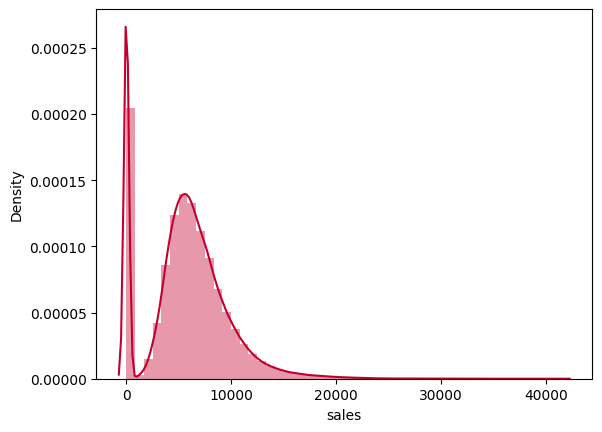

In [254]:
sns.distplot(df1['sales'], color='#c3002d')

C:\Users\Felipe\AppData\Local\Temp\ipykernel_30664\2186875571.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'], color='#c3002d')


<Axes: xlabel='competition_distance', ylabel='Density'>

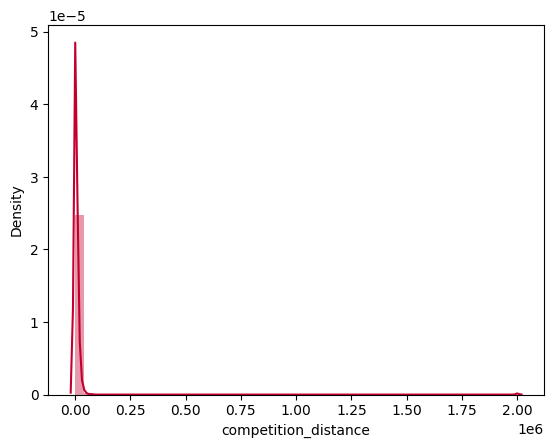

In [255]:
sns.distplot(df1['competition_distance'], color='#c3002d')

### 4.7.2 Categorical Attributes

In [24]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

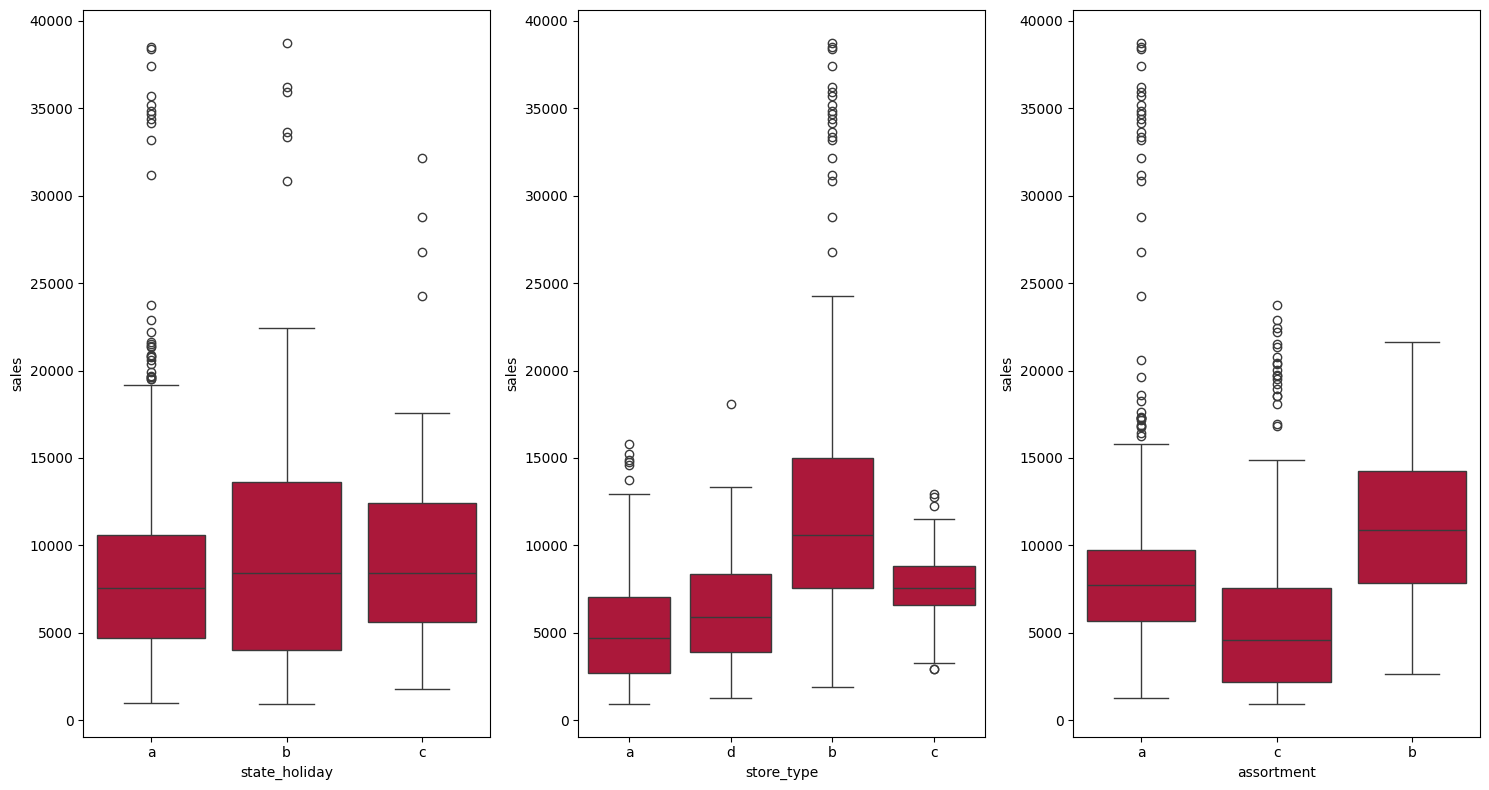

In [251]:
aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1, color='#c3002d')

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1, color='#c3002d')

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1, color='#c3002d')

plt.tight_layout()
plt.show()

# 5. Feature Engineering

In [28]:
df2 = df1.copy()

### 5.1 Hypothesis mind map

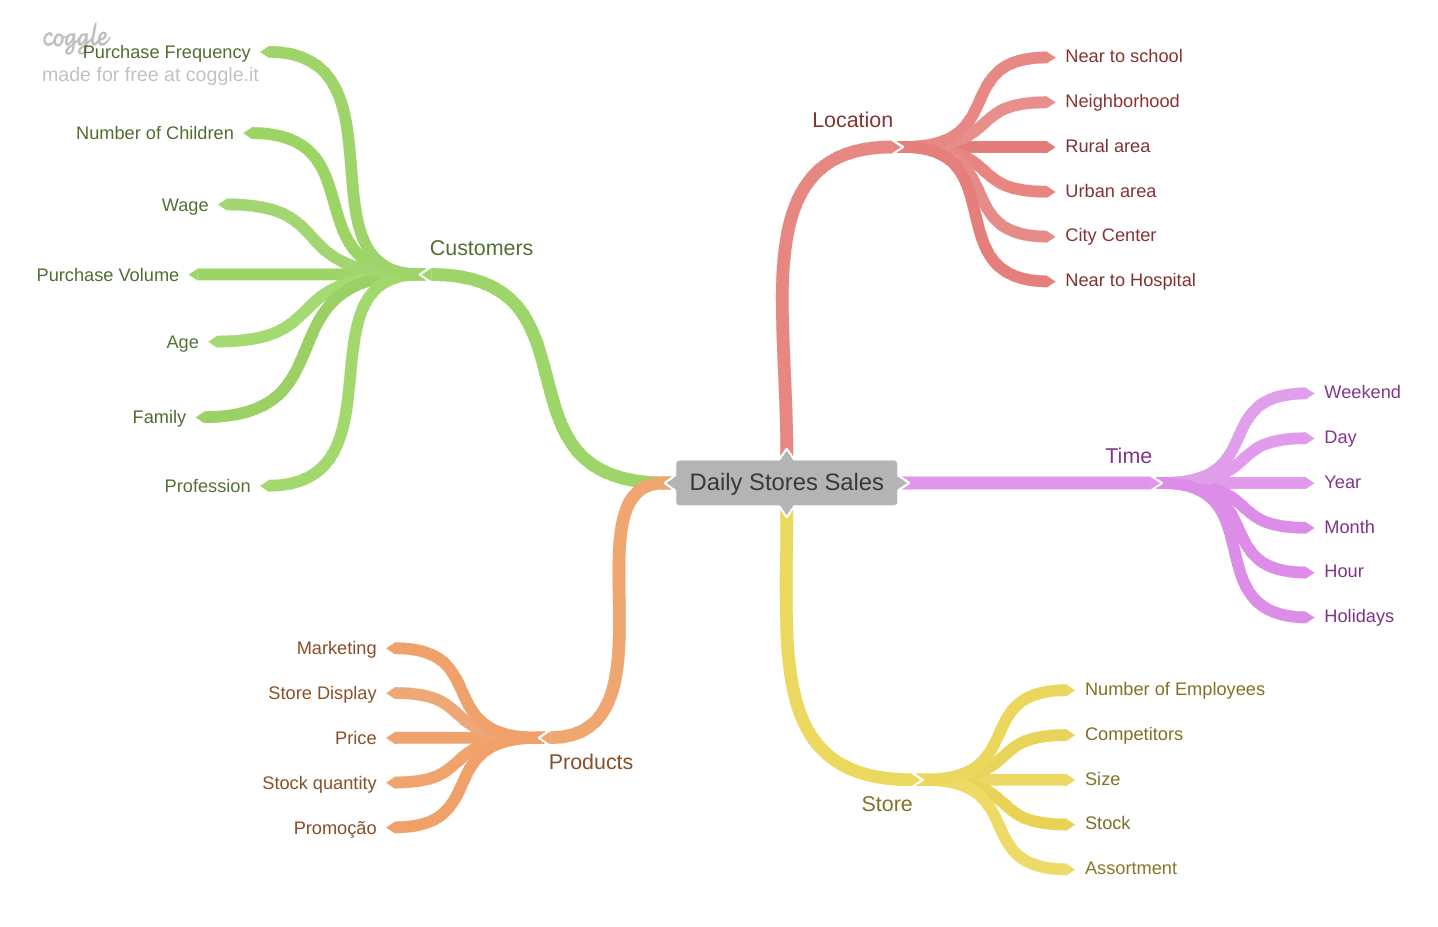

In [29]:
Image('img/mind_map.png')

### 5.2 Creation of hypotheses

#### 5.2.1 Store hypotheses

**1.** Stores with more employees should sell more

**2.** stores with more inventory should sell more

**3.** Smaller stores should sell less

**4.** Stores with a larger assortment should sell more

**5.** Stores with closer competitors should sell less

**6.** Stores with competitors for longer should sell more

#### 5.2.2 Product hypotheses

**1.** Stores that invest more in marketing should sell more

**2.** Stores that display more products should sell more

**3.** Stores with cheaper products should sell more

**4.** Stores with active promotions for longer should sell more

**5.** Stores with more promotion days should sell more

**6.** Stores with more consecutive promotions should sell more

#### 5.2.3 Time hypotheses

**1.** Stores should sell more over the years

**2.** Stores open at Christmas should sell more

**3.** Stores should sell more in the second half of the year

**4.** Stores should sell more after the 10th of each month

**5.** Stores should sell less on weekends

**6.** Stores should sell less during school holidays

### 5.3 Final list of hypotheses

**1.** Stores with a larger assortment should sell more

**2.** Stores with closer competitors should sell less

**3.** Stores with competitors for longer should sell more

**4.** Stores with active promotions for longer should sell more

**5.** Stores with more promotion days should sell more

**6.** Stores with more consecutive promotions should sell more

**7.** Stores should sell more over the years

**8.** Stores open at Christmas should sell more

**9.** Stores should sell more in the second half of the year

**10.** Stores should sell more after the 10th of each month

**11.** Stores should sell less on weekends

**12.** Stores should sell less during school holidays

### 5.4 Features

In [30]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


In [31]:
# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] ) /30 ).apply( lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))

df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days).astype(int)


In [32]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [33]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [34]:
df2['year'] = df2['year'].astype('int64')
df2['month'] = df2['month'].astype('int64')
df2['day'] = df2['day'].astype('int64')
df2['week_of_year'] = df2['week_of_year'].astype('int64')

In [35]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 6. Variable Filtering

In [36]:
df3 = df2.copy()

## 6.1 Filtering Rows

In [37]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 6.2 Column Selection

In [38]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis=1)

In [39]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 7. Exploratory Data Analysis

In [40]:
df4 = df3.copy()

## 7.1 Univariate Analysis

### 7.1.1 Response Variable

<Axes: xlabel='sales', ylabel='Count'>

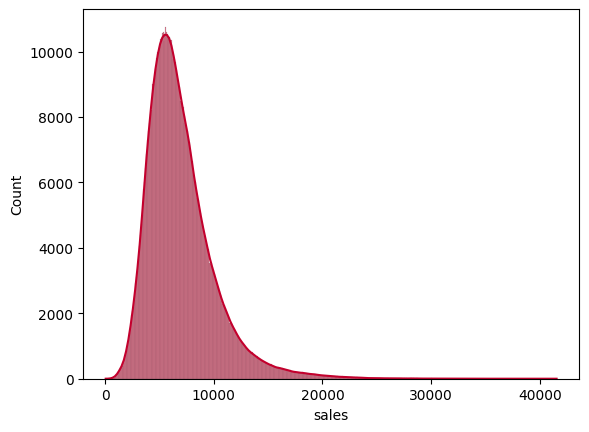

In [250]:
sns.histplot(df4['sales'], kde=True, color='#c3002d')

### 7.1.2 Numerical Variable

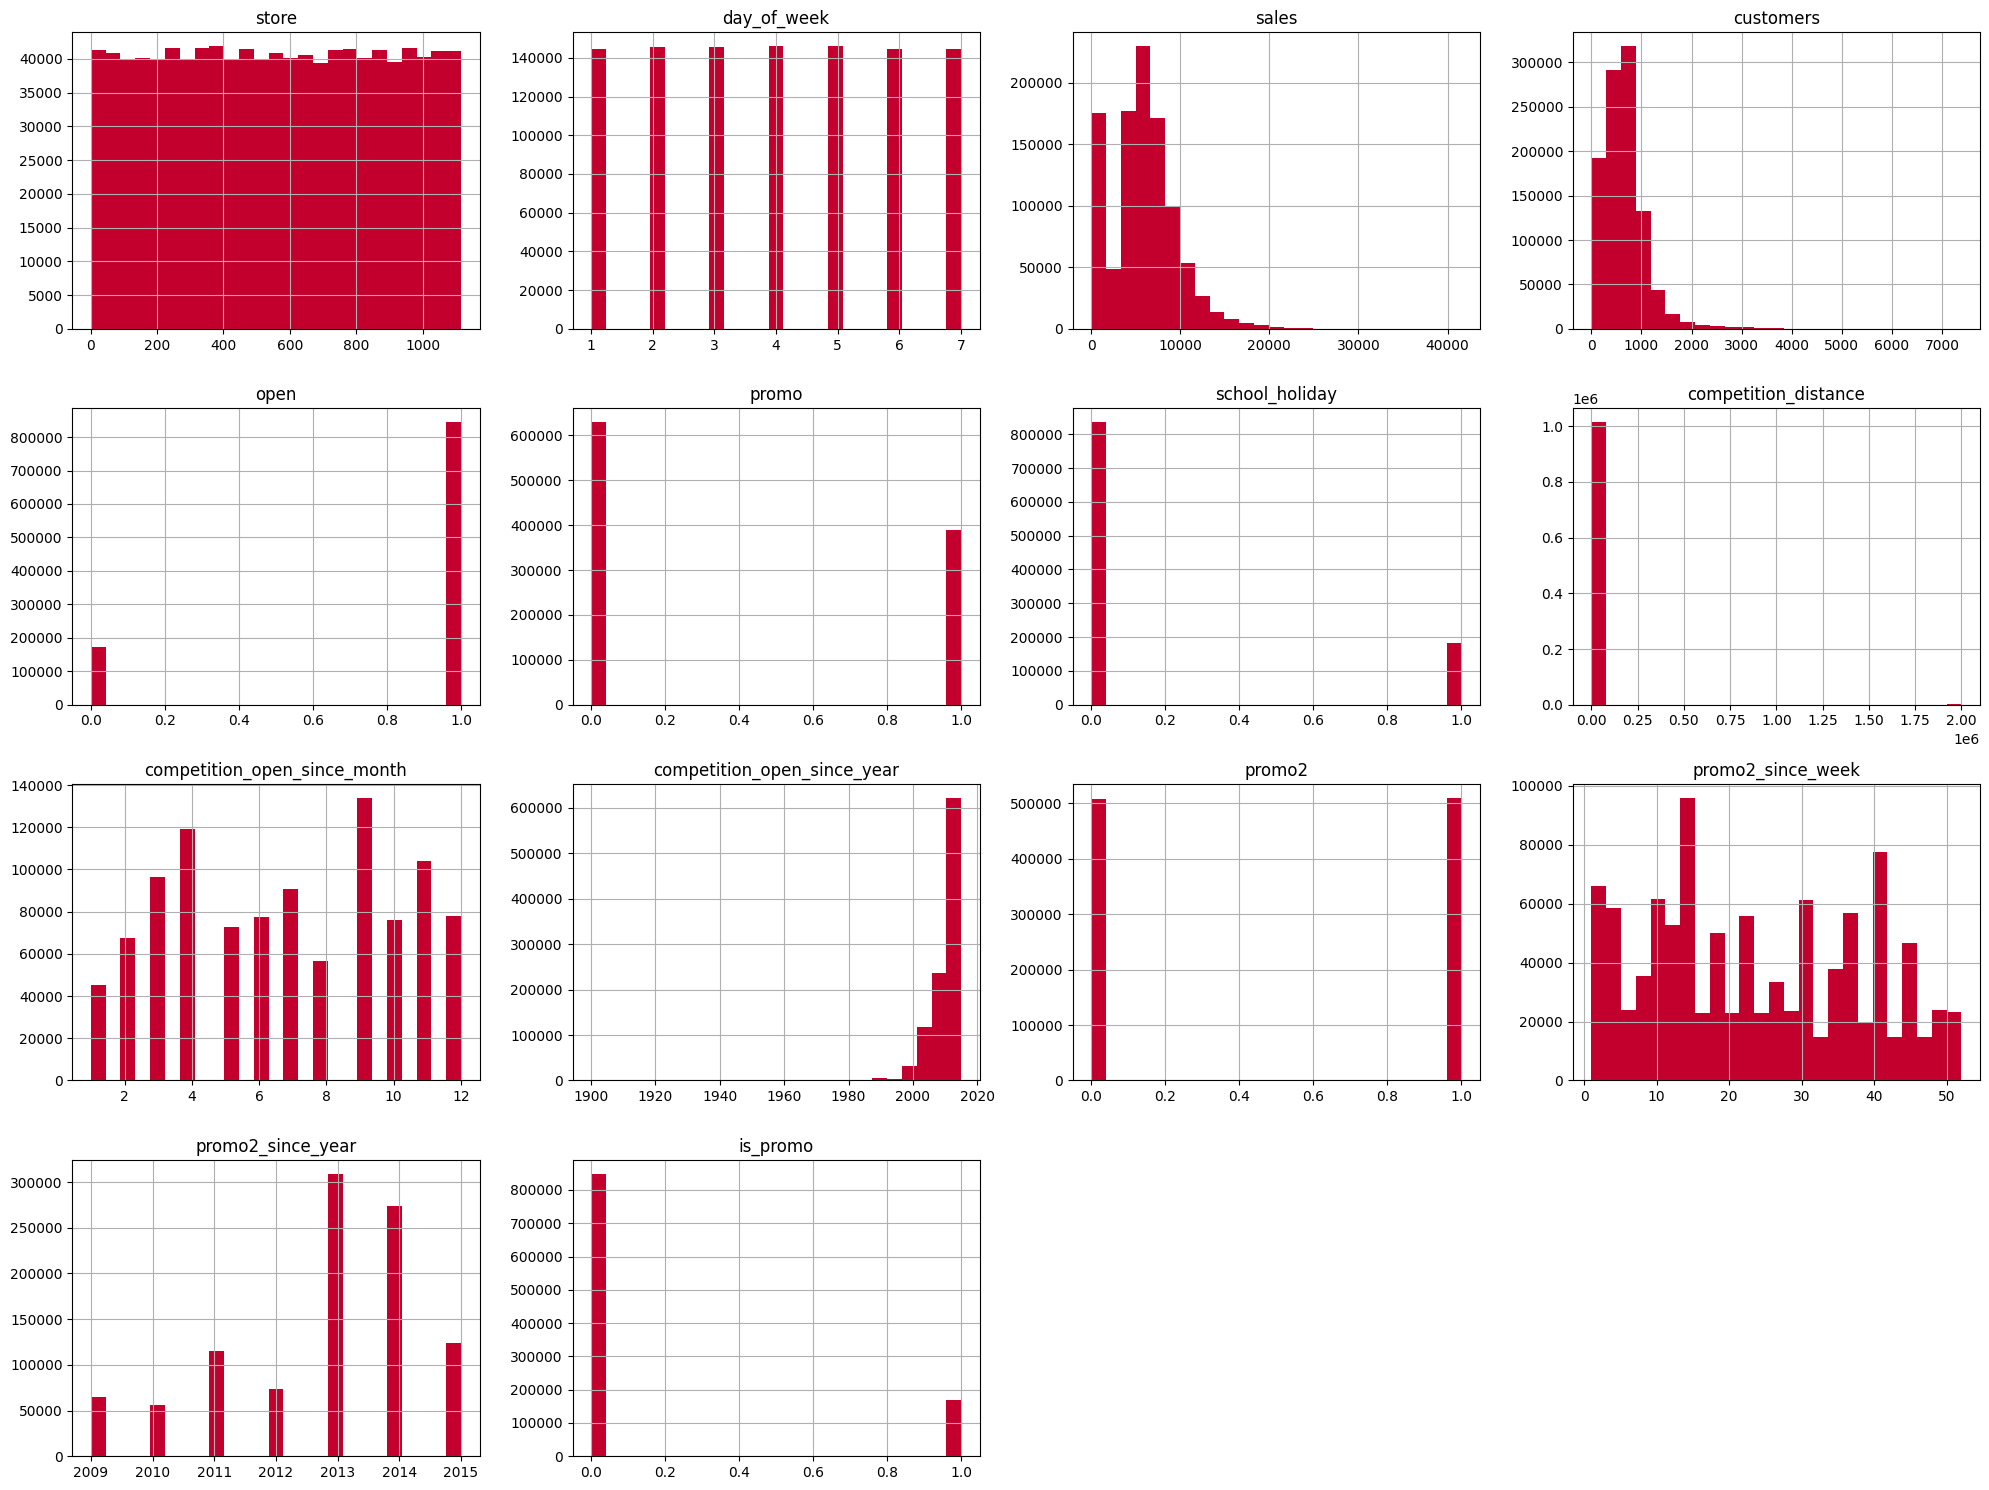

In [252]:

num_attributes.hist(bins=25, color='#c3002d', figsize=(20, 15));
plt.tight_layout()
plt.show()

### 7.1.3 Categorical Variable

In [43]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

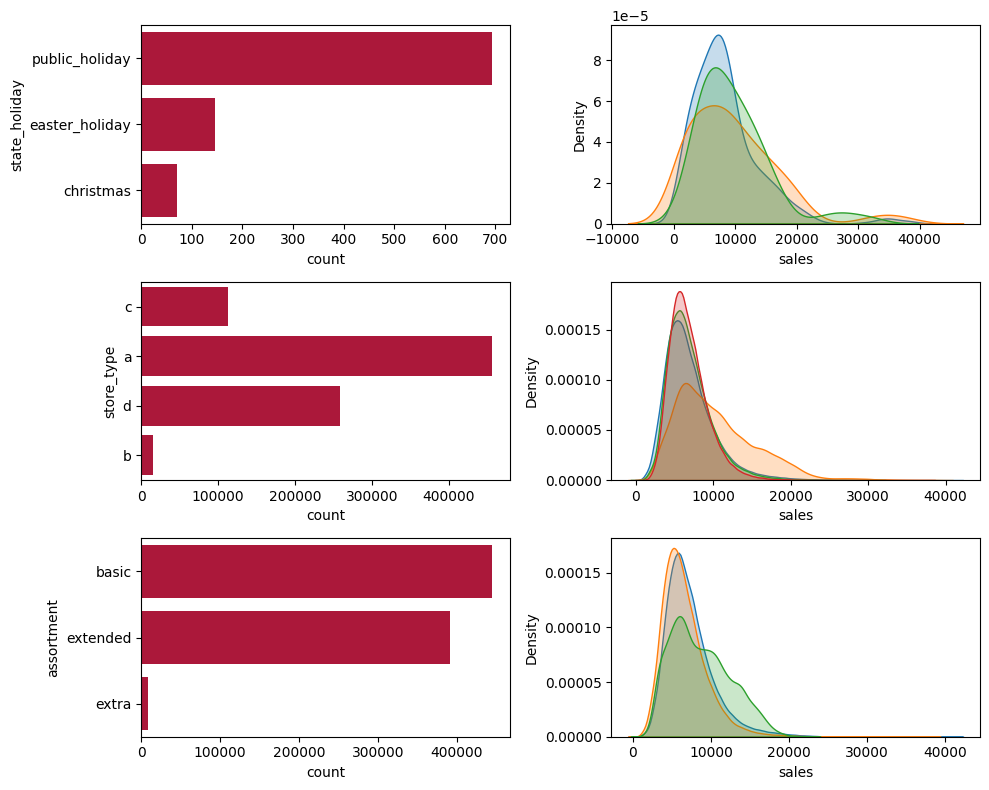

In [100]:
plt.figure(figsize=(10, 8))

# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'], color='#c3002d')

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'], color='#c3002d')

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'], color='#c3002d')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)

plt.tight_layout()

## 7.2 Bivariate Analysis

### **H1.** Stores with a larger assortment should sell more

#### **False hypothesis**: Stores with a larger assortment sell less

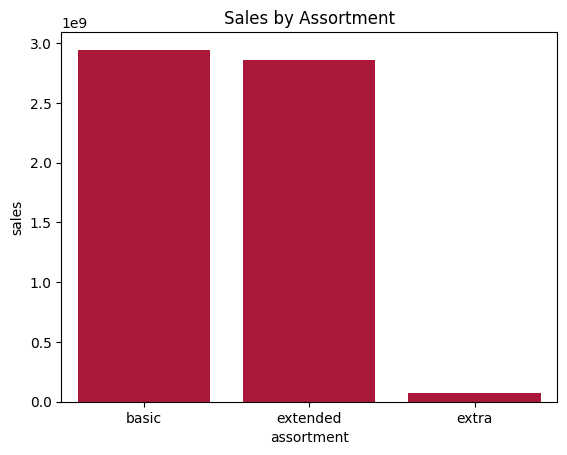

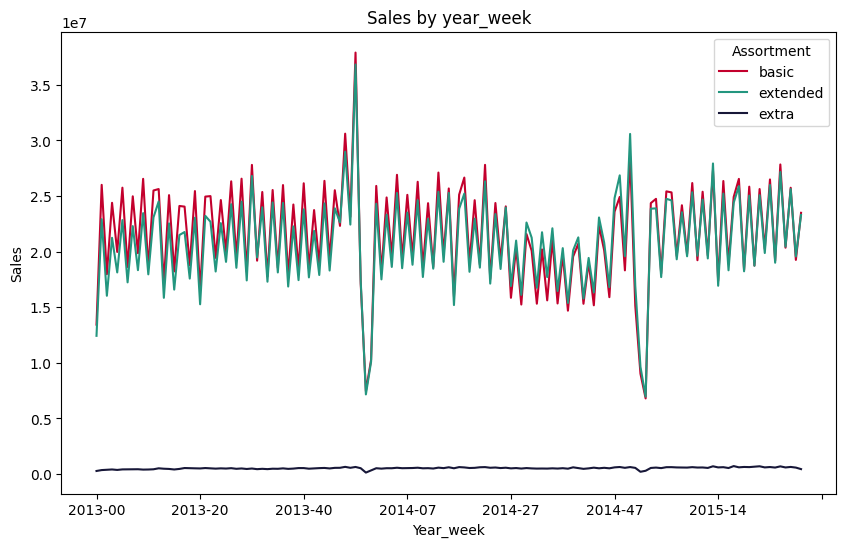

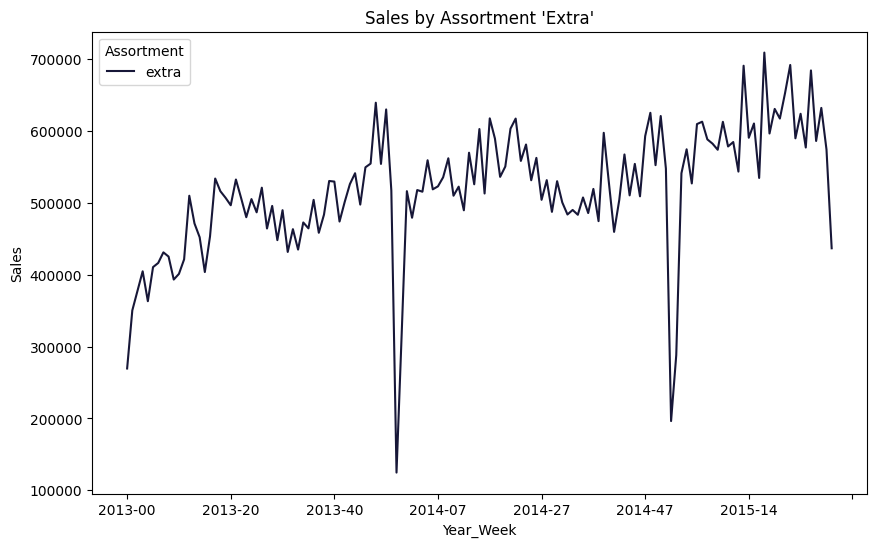

In [85]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, color='#c3002d');
plt.title("Sales by Assortment")

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
pivot_aux2 = aux2.pivot(index='year_week', columns='assortment', values='sales')
pivot_aux2.plot(color={'basic': '#c3002d', 'extra': '#171738', 'extended': '#23967F'}, figsize=(10, 6))
plt.title("Sales by year_week")
plt.xlabel("Year_week")
plt.ylabel("Sales")
plt.legend(title="Assortment")
plt.show()


aux3 = aux2[aux2['assortment'] == 'extra']
pivot_aux3 = aux3.pivot(index='year_week', columns='assortment', values='sales')
pivot_aux3.plot(color='#171738', figsize=(10, 6))
plt.title("Sales by Assortment 'Extra'")
plt.xlabel("Year_Week")
plt.ylabel("Sales")
plt.legend(title="Assortment")
plt.show()


### **H2.** Stores with closer competitors should sell less

#### **False hypothesis**: Stores with closer competitors sell more

C:\Users\Felipe\AppData\Local\Temp\ipykernel_30664\2179905558.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()


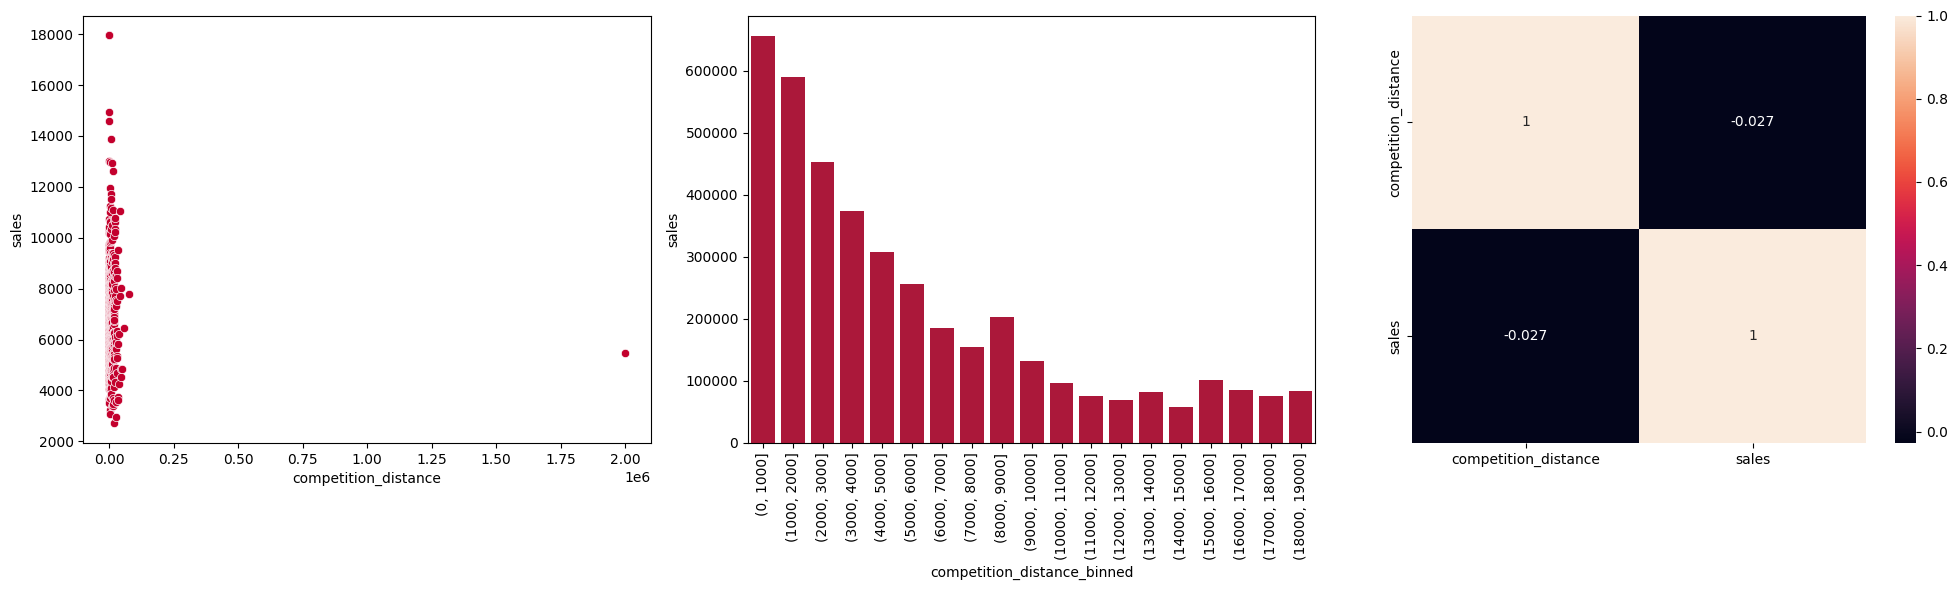

In [213]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1, color='#c3002d');

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x='competition_distance_binned', y='sales', data=aux2, color='#c3002d');
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(df4[['competition_distance', 'sales']].corr(method='pearson'), annot=True);

plt.tight_layout()
plt.show()

### **H3.** Stores with competitors for longer should sell more

#### **False hypothesis**: Stores with newer competitors sell more

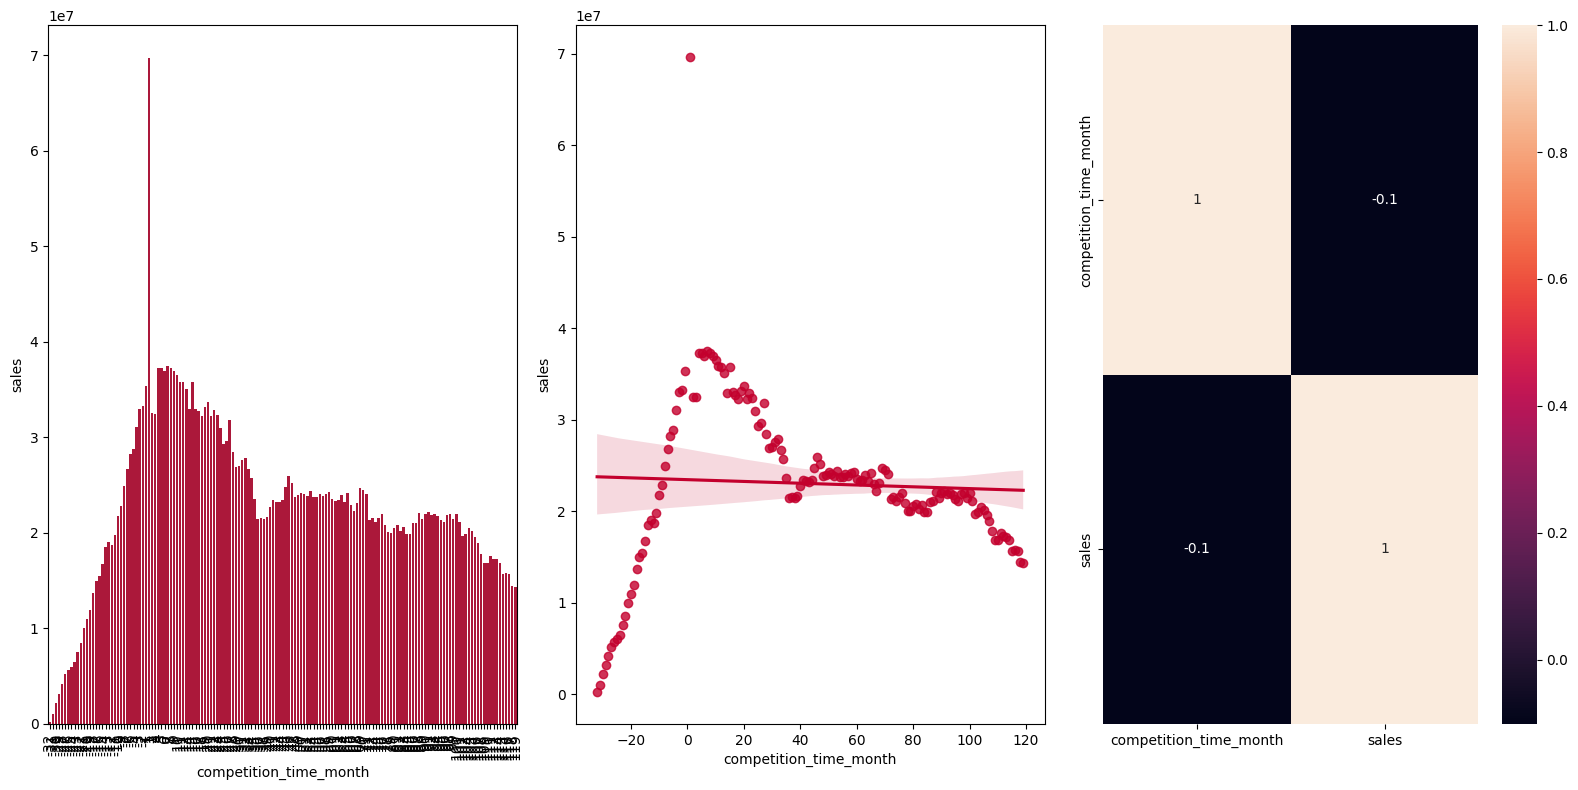

In [94]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2, color='#c3002d');
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2, color='#c3002d');

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.tight_layout()
plt.show()

### **H4.** Stores with active promotions for longer should sell more

#### **False Hypothesis**: Stores sell regularly until a certain period of active promotion, then sales drop

Text(0, 0.5, 'Sales')

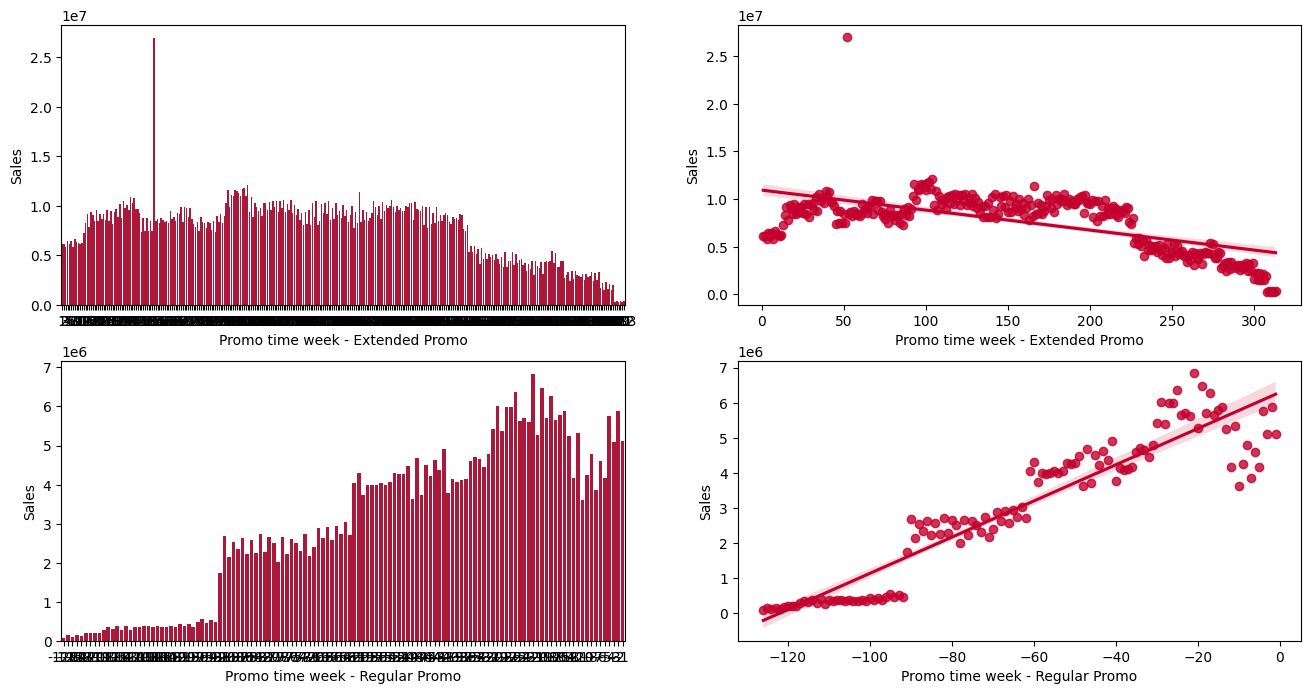

In [106]:
plt.figure(figsize=(16, 8))
# plt.subplot(1, 3, 1)
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(2, 2, 1)
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promo
sns.barplot(x='promo_time_week', y='sales', data=aux2, color='#c3002d');
plt.xlabel('Promo time week - Extended Promo')
plt.ylabel('Sales')

plt.subplot(2, 2, 2)
sns.regplot(x='promo_time_week', y='sales', data=aux2, color='#c3002d');
plt.xlabel('Promo time week - Extended Promo')
plt.ylabel('Sales')

plt.subplot(2, 2, 3)
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promo
sns.barplot(x='promo_time_week', y='sales', data=aux3, color='#c3002d');
plt.xlabel('Promo time week - Regular Promo')
plt.ylabel('Sales')

plt.subplot(2, 2, 4)
sns.regplot(x='promo_time_week', y='sales', data=aux3, color='#c3002d');
plt.xlabel('Promo time week - Regular Promo')
plt.ylabel('Sales')

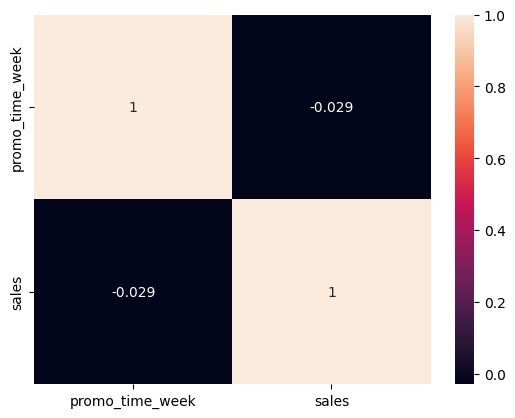

In [49]:
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>**H5.** Stores with more promotion days should sell more</s>

### **H6.** Stores with more consecutive promotions should sell more

#### **False hypothesis**: stores with more consecutive promotions sell less

In [50]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales', ascending=True)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


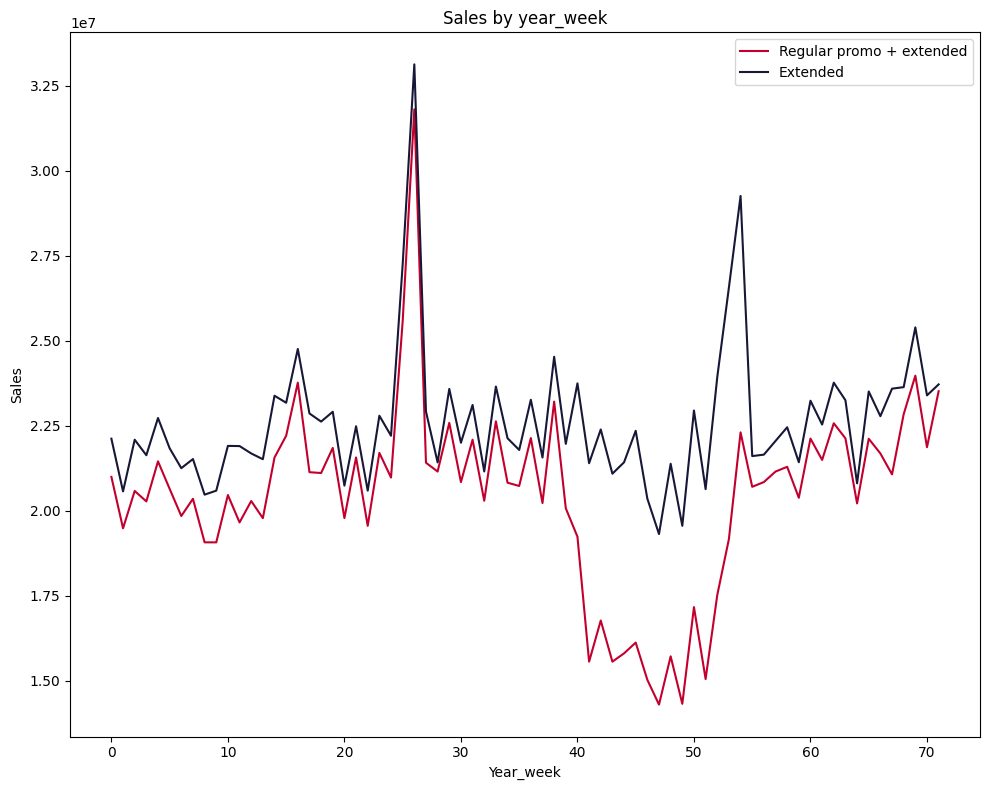

In [125]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(color='#c3002d')

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax, figsize=(10, 8), color='#171738')

ax.legend(labels=['Regular promo + extended', 'Extended'])

plt.title("Sales by year_week")
plt.xlabel("Year_week")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

### **H7.** Stores should sell more over the years

#### **False Hypothesis**: Stores sell less over the years

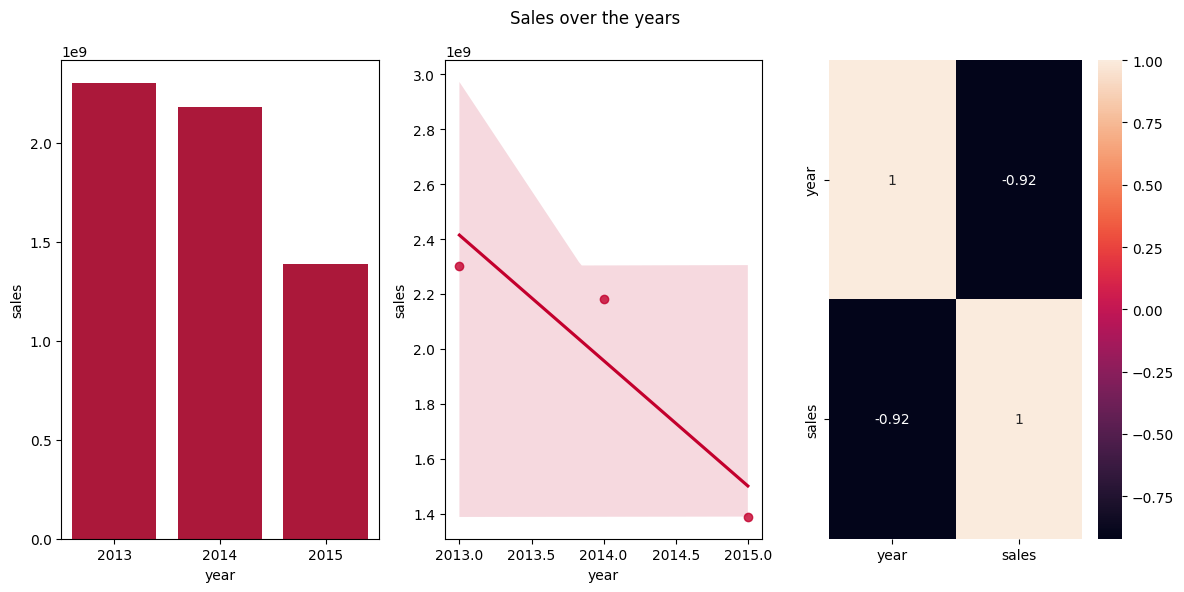

In [143]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1, color='#c3002d');

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1, color='#c3002d');

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.suptitle('Sales over the years')
plt.tight_layout()
plt.show()

### **H8.** Stores open at Christmas should sell more

#### **False Hypothesis**: Stores open at Christmas sell less

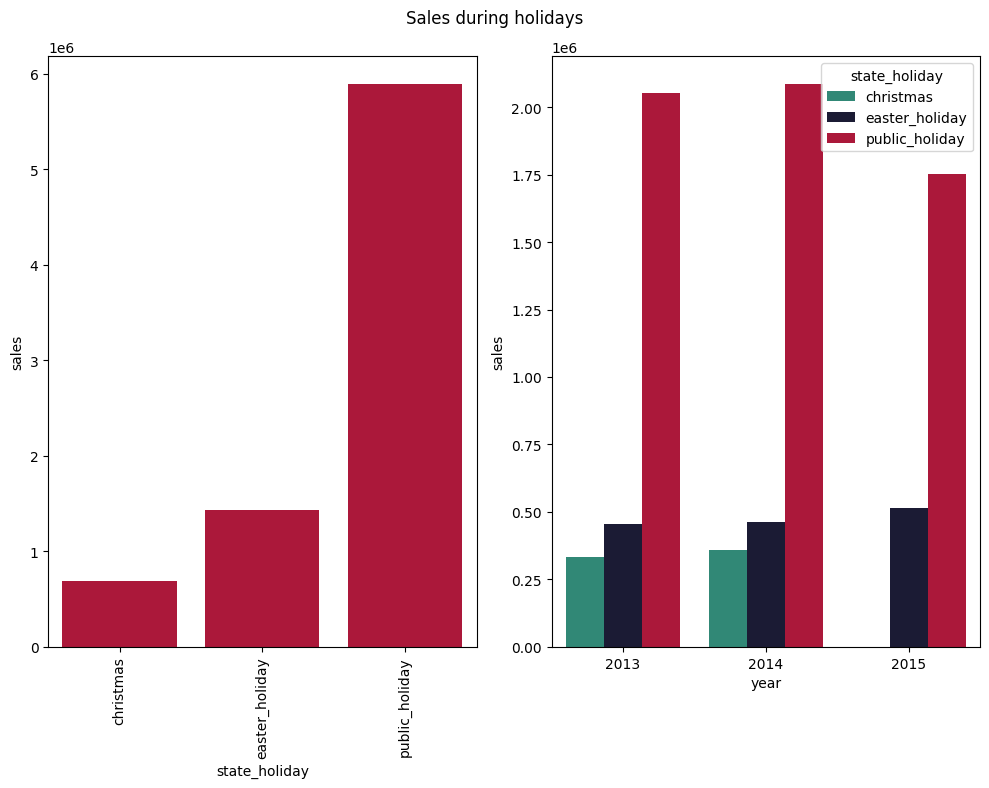

In [148]:
plt.figure(figsize=(10, 8))
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1, color='#c3002d');
plt.xticks(rotation=90);


plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()

palette = {'christmas': '#23967F', 'easter_holiday': '#171738', 'public_holiday': '#c3002d'}

sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2, palette=palette);

plt.suptitle('Sales during holidays')
plt.tight_layout()
plt.show()

### **H9.** Stores should sell more in the second half of the year

#### **False Hypothesis**: Stores sell less in the second half of the year

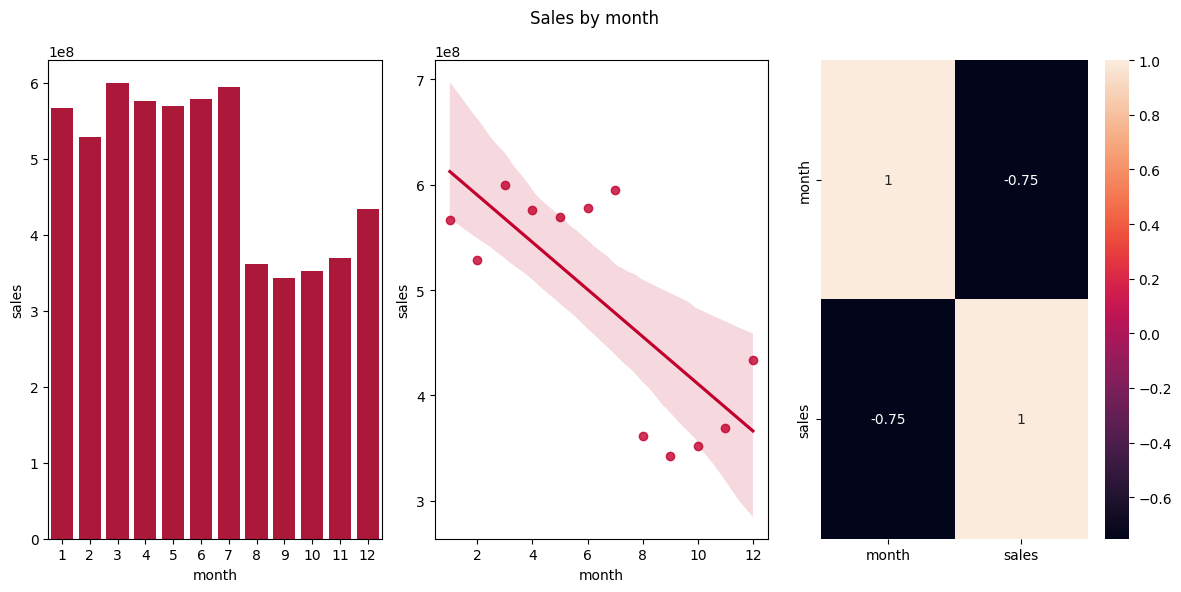

In [152]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1, color='#c3002d');

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1, color='#c3002d');

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.suptitle('Sales by month')
plt.tight_layout()
plt.show()

### **H10.** Stores should sell more after the 10th of each month

#### **True hypothesis!**

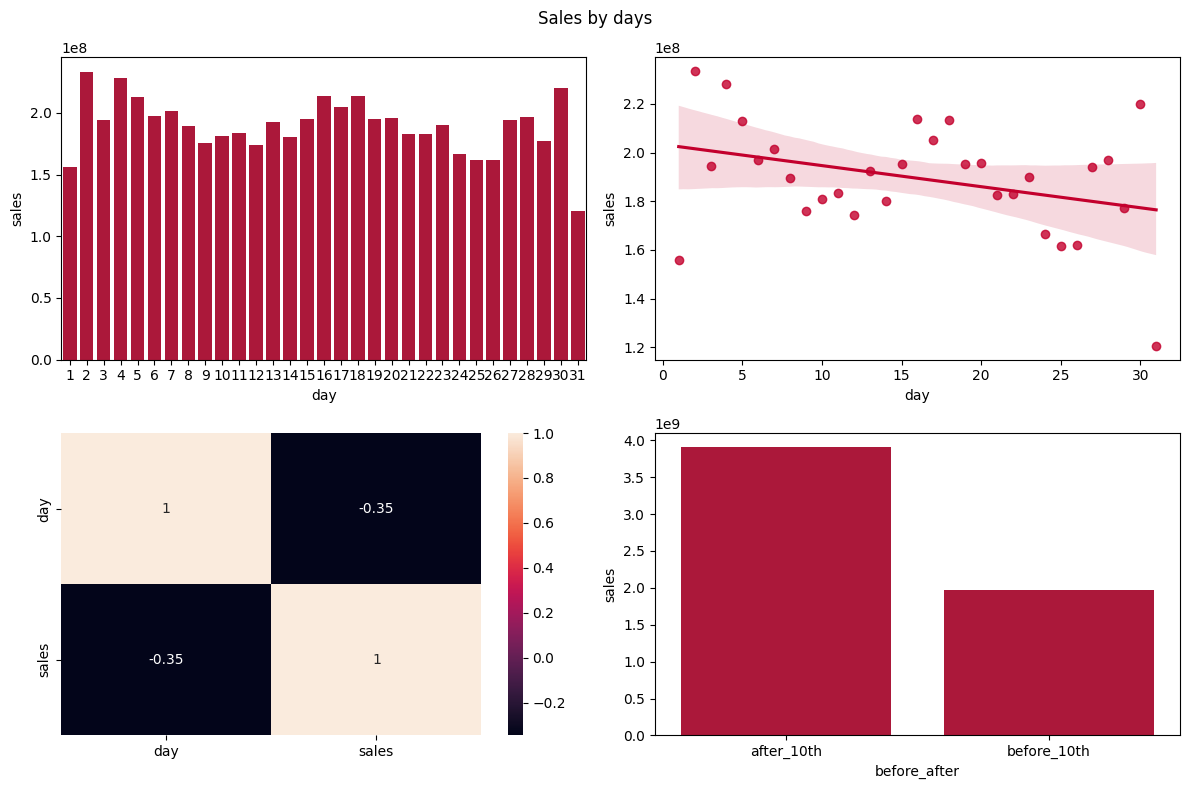

In [158]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1, color='#c3002d');

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1, color='#c3002d');

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10th' if x <= 10 else 'after_10th')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

sns.barplot(x='before_after', y='sales', data=aux2, color='#c3002d');

plt.suptitle('Sales by days')
plt.tight_layout()
plt.show()

### **H11.** Stores should sell less on weekends

#### **True Hypothesis!**

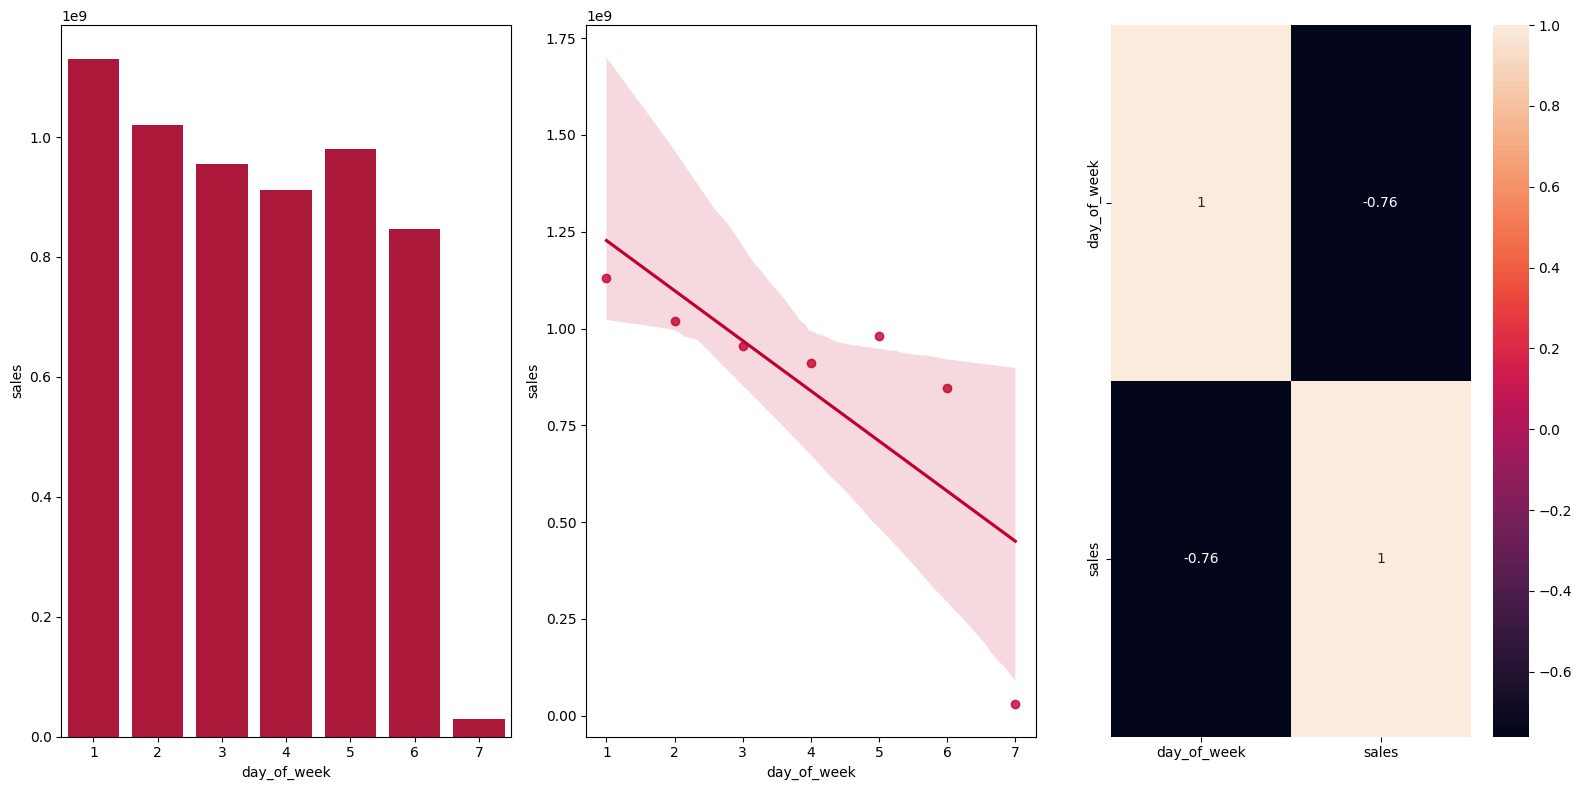

In [73]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1, color='#C3002D');

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1, color='#C3002D');

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.tight_layout()
plt.show()

### **H12.** Stores should sell less during school holidays

#### **True hypothesis**: Stores sell less during school holidays, except in the months of July and August

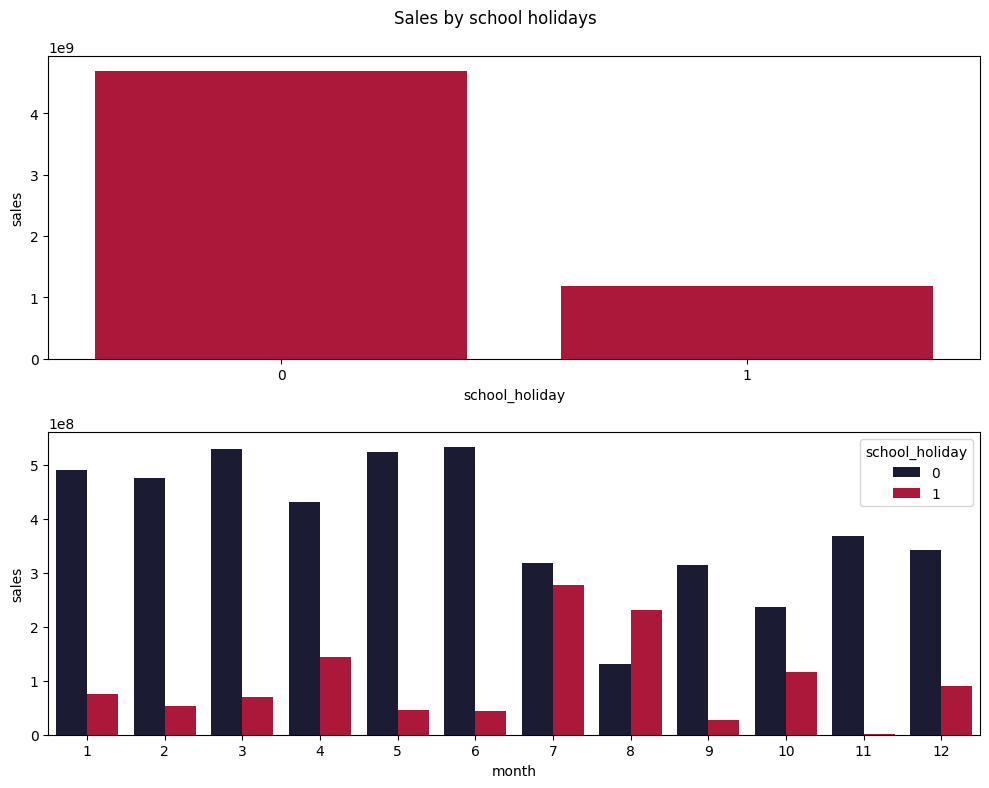

In [165]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1, color='#c3002d');

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
palette = {0: '#171738', 1: '#c3002d'}
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2, palette=palette);

plt.suptitle('Sales by school holidays')
plt.tight_layout()
plt.show()

## **Summary**

In [76]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low'],
    ]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 7.3 Multivariate Analysis

### 7.3.1 Numerical Attributes

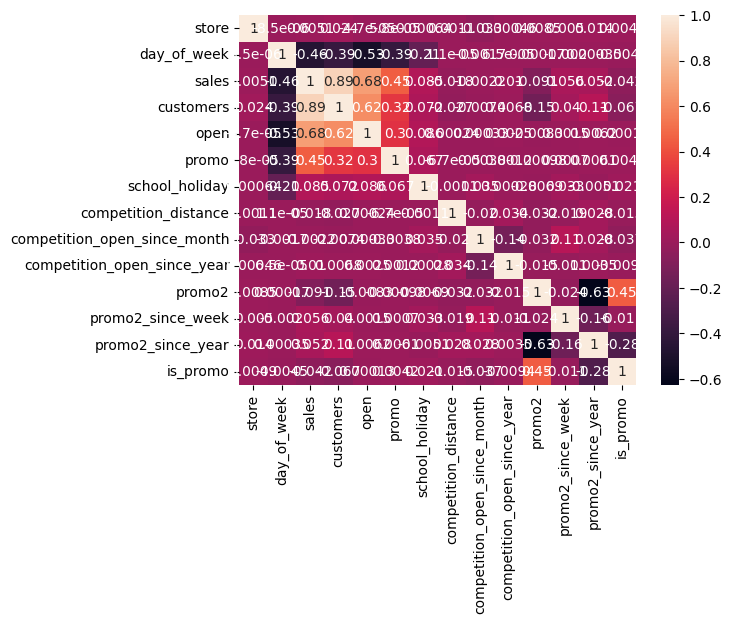

In [167]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 7.3.2 Categorical Attributes

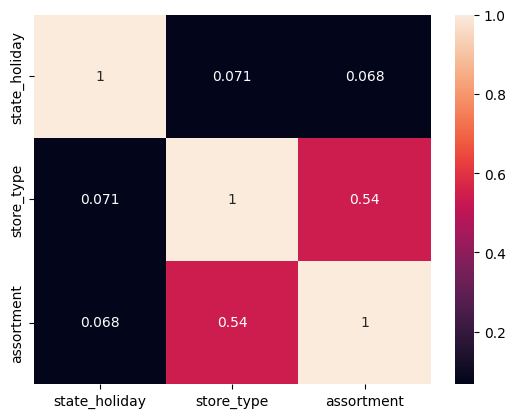

In [168]:
# Only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer v
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 8. Data Preparation

In [169]:
df5 = df4.copy()

## 8.1 Normalization

In [170]:
# There are no normalizable variables. 

## 8.2 Rescaling

In [171]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb' ) )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb' ) )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( mms, open( 'parameter/promo_time_week_scaler.pkl', 'wb' ) )

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb' ) )

## 8.3 Transformation

### 8.3.1 Enconding

In [172]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb' ) )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 8.3.2 Response Variable Transformation

In [173]:
df5['sales'] = np.log1p( df5['sales'] )

### 8.3.3 Nature Transformation

In [174]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) ) 
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) ) 

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) ) 
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) ) 

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30 ) ) ) 
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30 ) ) ) 

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) ) 
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) ) 

# 9. Feature Selection

In [175]:
df6 = df5.copy()

## 9.1 Split dataframe into training and test

In [176]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [177]:
# Separating the dataframes from the first sale to six weeks before the last sale

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6 * 7)

Timestamp('2015-06-19 00:00:00')

In [178]:
# training dataset
X_train = df6[ df6['date'] < '2015-06-19' ]
y_train = X_train['sales']

# test dataset
X_test = df6[ df6['date'] >= '2015-06-19' ]
y_test = X_test['sales']

print(f'Training Min Date: {X_train["date"].min()}')
print(f'Training Max Date: {X_train["date"].max()}')

print(f'\nTest Min Date: {X_test["date"].min()}')
print(f'Test Max Date: {X_test["date"].max()}')

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 9.2 Boruta as feature selector

In [108]:
# training and test dataset for boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


In [62]:
# best features from boruta

cols_selected = boruta.support_.tolist()

X_train_fs = X_train.drop( ['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected features boruta

cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta ))

NameError: name 'boruta' is not defined

In [110]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [111]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 9.3 Manual Feature Selection

In [179]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']


# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [180]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 10. Machine Learning Modeling

In [181]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]


# Time Series data preparation 
x_training = X_train[ cols_selected_boruta_full ]

## 10.1 Average Model

In [182]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) ) 
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 10.2 Linear Regression Model 

In [183]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1863.628669,0.292165,2673.142689


### 10.2.1 Linear Regression Model - Cross Validation

In [129]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2083.17 +/- 294.98,0.3 +/- 0.02,2958.87 +/- 466.72


## 10.3 Linear Regression Regularized Model - Lasso

In [68]:
# model
lrr = Lasso(alpha=0.01).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1889.982643,0.288951,2745.968967


### 10.3.1 Linear Regression Regularized Model - Lasso - Cross Validation

In [130]:
lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Lasso,2117.66 +/- 340.94,0.29 +/- 0.01,3061.89 +/- 503.23


## 10.4 Random Forest Regressor

In [69]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 10.4.1 Random Forest Regressor - Cross Validation

In [131]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold number:5

KFold number:4

KFold number:3

KFold number:2

KFold number:1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 10.5 XGBoost Regressor

In [75]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1683.842595,0.249763,2464.956597


### 10.5.1 XGBoost Regressor - Cross Validation

In [132]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold number:5

KFold number:4

KFold number:3

KFold number:2

KFold number:1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1858.17 +/- 290.66,0.25 +/- 0.01,2686.29 +/- 432.14


## 10.6 Comparing Models Performances

## 10.6.1 Single Performance (1 fold)

In [76]:
comparing_models_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
comparing_models_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.206400,1835.135542
0,XGBoost Regressor,1683.842595,0.249763,2464.956597
0,Linear Regression,1863.628669,0.292165,2673.142689
0,Linear Regression - Lasso,1889.982643,0.288951,2745.968967


## 10.6.2 Real Performance - Cross Validation

In [136]:
comparing_models_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
comparing_models_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,1858.17 +/- 290.66,0.25 +/- 0.01,2686.29 +/- 432.14
0,Linear Regression,2083.17 +/- 294.98,0.3 +/- 0.02,2958.87 +/- 466.72
0,Linear Regression Lasso,2117.66 +/- 340.94,0.29 +/- 0.01,3061.89 +/- 503.23


# 11. Hyperparameter Fine Tuning

## 11.1 Random Search

In [144]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15],
}

MAX_EVAL = 10

In [145]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )



    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                n_estimators=hp['n_estimators'],
                                eta=hp['eta'],
                                max_depth=hp['max_depth'],
                                subsample=hp['subsample'],
                                colsample_bytree=hp['colsample_bytree'],
                                min_child_weight=hp['min_child_weight'])

    # performance
    result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3,

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1086.86 +/- 65.52,0.14 +/- 0.0,1590.18 +/- 127.78
0,XGBoost Regressor,947.92 +/- 77.55,0.13 +/- 0.01,1377.46 +/- 149.75
0,XGBoost Regressor,1508.23 +/- 54.28,0.2 +/- 0.0,2193.29 +/- 98.21
0,XGBoost Regressor,1495.77 +/- 43.49,0.2 +/- 0.0,2201.97 +/- 82.91
0,XGBoost Regressor,1412.17 +/- 52.09,0.19 +/- 0.0,2057.32 +/- 96.26
0,XGBoost Regressor,1050.1 +/- 80.43,0.14 +/- 0.01,1508.83 +/- 143.42
0,XGBoost Regressor,1817.76 +/- 54.34,0.25 +/- 0.0,2646.65 +/- 98.27
0,XGBoost Regressor,928.0 +/- 81.58,0.13 +/- 0.01,1327.3 +/- 142.38
0,XGBoost Regressor,1787.12 +/- 50.54,0.24 +/- 0.0,2604.46 +/- 90.92
0,XGBoost Regressor,835.73 +/- 81.75,0.11 +/- 0.01,1216.21 +/- 150.97


## 11.2 Final Model

In [185]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.01,
    'max_depth': 9,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 8,
}

In [186]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight']).fit( x_train, y_train )
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )


# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,663.329609,0.096535,975.273178


# 12. Error Interpretation

In [214]:
df7 = X_test[ cols_selected_boruta_full ]

# rescale
df7['sales'] = np.expm1( df7['sales'] )
df7['predictions'] = np.expm1( yhat_xgb_tuned )

C:\Users\Felipe\AppData\Local\Temp\ipykernel_30664\654623752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['sales'] = np.expm1( df7['sales'] )
C:\Users\Felipe\AppData\Local\Temp\ipykernel_30664\654623752.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['predictions'] = np.expm1( yhat_xgb_tuned )


## 12.1 Business Performance

In [215]:
# sum of predictions
df7_aux1 = df7[[ 'store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df7_aux2 = df7[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename(columns={0: 'MAE'})
df7_aux3 = df7[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename(columns={0: 'MAPE'})

# Merge
df7_aux4 = pd.merge( df7_aux2, df7_aux3, how='inner', on='store')
df7_aux5 = pd.merge( df7_aux1, df7_aux4, how='inner', on='store')

# Scenarios
df7_aux5['worst_scenario'] = df7_aux5['predictions'] - df7_aux5['MAE']
df7_aux5['best_scenario'] = df7_aux5['predictions'] + df7_aux5['MAE']

# Order columns
df7_aux5 = df7_aux5[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

df7_aux5.head()

C:\Users\Felipe\AppData\Local\Temp\ipykernel_30664\1023240961.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df7_aux2 = df7[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename(columns={0: 'MAE'})
C:\Users\Felipe\AppData\Local\Temp\ipykernel_30664\1023240961.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df7

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,167220.671875,166932.931812,167508.411938,287.740063,0.066310
1,2,180661.312500,180259.161265,181063.463735,402.151235,0.081571
2,3,257746.140625,257202.956101,258289.325149,543.184524,0.074892
3,4,338747.687500,337809.071896,339686.303104,938.615604,0.089838
4,5,171284.875000,170930.280966,171639.469034,354.594034,0.080855


In [249]:
df7_aux5['MAPE'].mean()

np.float64(0.09693028647026561)

<Axes: xlabel='store', ylabel='MAPE'>

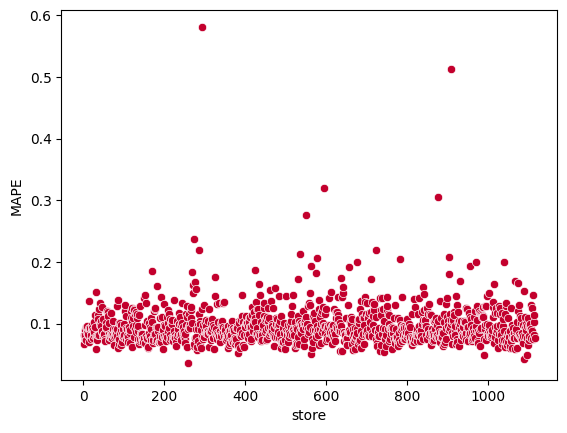

In [217]:
sns.scatterplot( x='store', y='MAPE', data=df7_aux5, color='#c3002d')

## 12.2 Total Performance

In [171]:
df7_aux6 = (df7_aux5[['predictions', 'worst_scenario', 'best_scenario']].apply( 
                        lambda x: np.sum( x ), axis=0).reset_index().rename( 
                        columns={'index': 'Scenarios', 0: 'Values'} ))

df7_aux6['Values'] = df7_aux6['Values'].map( 'US$ {:,.2f}'.format )

df7_aux6

,Scenarios,Values
0,predictions,"US$ 283,476,320.00"
1,worst_scenario,"US$ 282,732,852.35"
2,best_scenario,"US$ 284,219,747.87"


## 12.3 Machine Learning Performance

In [224]:
df7['error'] = df7['sales'] - df7['predictions']
df7['error_rate'] = df7['predictions'] / df7['sales']

C:\Users\Felipe\AppData\Local\Temp\ipykernel_30664\1370162162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['error'] = df7['sales'] - df7['predictions']
C:\Users\Felipe\AppData\Local\Temp\ipykernel_30664\1370162162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['error_rate'] = df7['predictions'] / df7['sales']


C:\Users\Felipe\AppData\Local\Temp\ipykernel_30664\1480008082.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df7['error'], color='#c3002d')


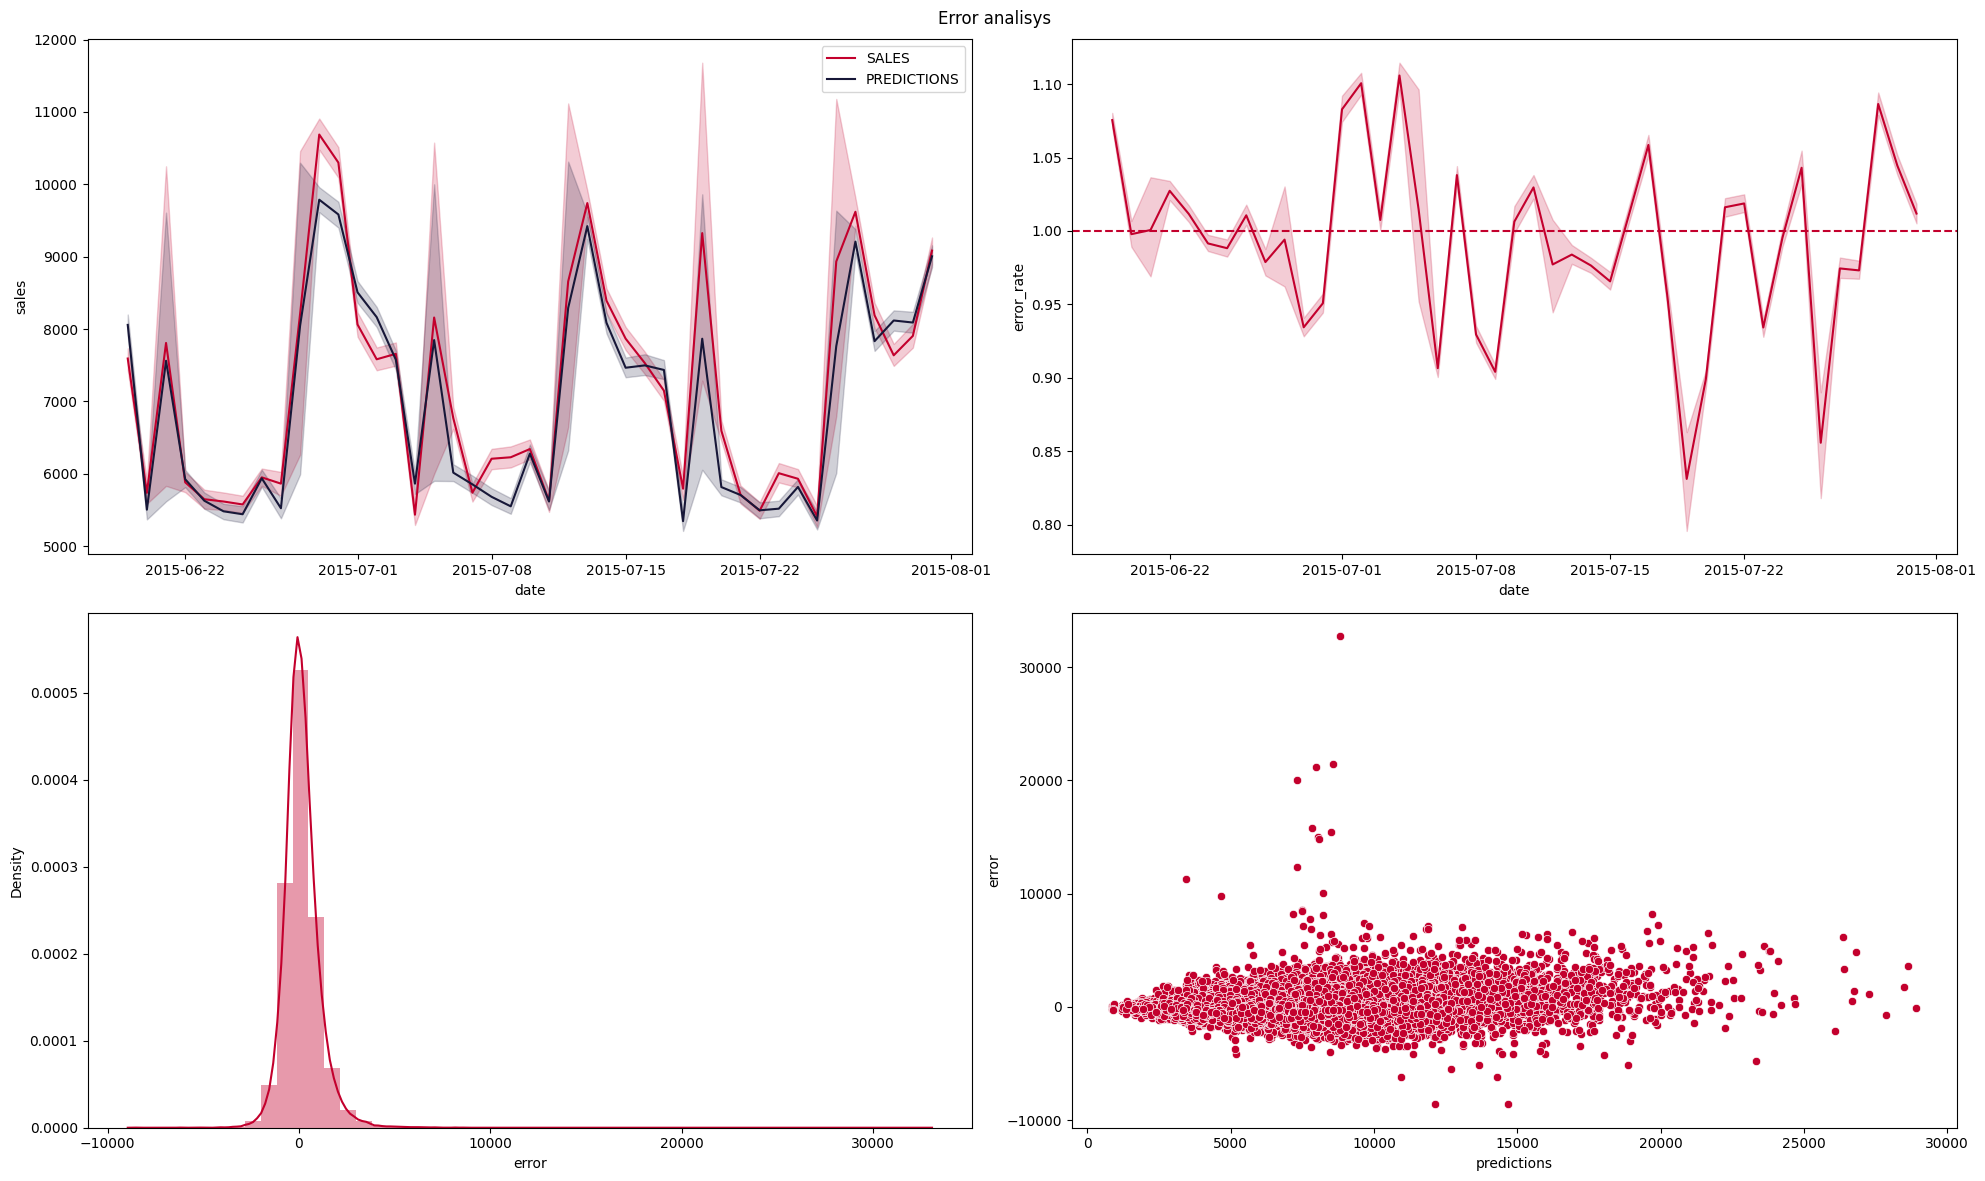

In [247]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
sns.lineplot( x='date', y='sales', data=df7, label='SALES', color='#c3002d')
sns.lineplot( x='date', y='predictions', data=df7, label='PREDICTIONS', color='#171738')

plt.subplot(2, 2, 2)
sns.lineplot( x='date', y='error_rate', data=df7, color='#c3002d')
plt.axhline(1, linestyle='--', color='#c3002d')

plt.subplot(2, 2, 3)
sns.distplot( df7['error'], color='#c3002d')

plt.subplot(2, 2, 4)
sns.scatterplot( x= df7['predictions'], y= df7['error'], color='#c3002d')


plt.suptitle('Error analisys')
plt.tight_layout()
plt.show()

# 13. Deploy Model to Production

In [195]:
pickle.dump( model_xgb_tuned, open( 'model/model_xgb_tuned_rossmann.pkl', 'wb') )

## 13.1 Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math

class Rossmann( object ):


    def __init__(self):

        self.home_path = 'C:/Users/Felipe/Documents/Felipe/Cursos/CientistaDados/repos/ds_production/rossmann_project/'

        self.competition_distance_scaler = pickle.load( open( 
            self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        
        self.competition_time_month_scaler = pickle.load( open( 
            self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        
        self.promo_time_week_scaler = pickle.load( open(
            self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb' ))
        
        self.year_scaler = pickle.load(open(
            self.home_path + 'parameter/year_scaler.pkl', 'rb'))

        self.store_type_scaler = pickle.load( open( 
            self.home_path + 'parameter/store_type_scaler.pkl', 'rb' ))


    def data_cleaning( self, df1 ):

        # rename columns

        old_cols = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType',
                    'Assortment', 'CompetitionDistance',
                    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear',
                    'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)
        new_cols = list( map( snakecase, old_cols ) )
        df1.columns = new_cols

        # data types
        
        df1['date'] = pd.to_datetime(df1['date'])


        # competition_distance
        # assigns a huge number to the distance cause 
        # it's like there's no competition
        df1['competition_distance'] = (df1['competition_distance']
                                    .apply(lambda x: 2000000.0 if math.isnan(x) 
                                            else x))

        # competition_open_since_month

        df1['competition_open_since_month'] = (df1.apply(
            lambda x: x['date'].month if math.isnan(
                x['competition_open_since_month']) else 
                x['competition_open_since_month'], axis=1))

        # competition_open_since_year

        df1['competition_open_since_year'] = (df1.apply(
            lambda x: x['date'].year if math.isnan(
                x['competition_open_since_year']) else 
                x['competition_open_since_year'], axis=1))
                        
        # promo2_since_week

        df1['promo2_since_week'] = (df1.apply(
            lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
            else x['promo2_since_week'], axis=1))

        # promo2_since_year

        df1['promo2_since_year'] = (df1.apply(
            lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
            else x['promo2_since_year'], axis=1))
        
        # promo_interval

        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov',
                    12: 'Dec'}

        df1['promo_interval'].fillna( 0 )

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        # is_promo
        
        df1['is_promo'] = (df1[['promo_interval', 'month_map']].apply(
            lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] 
            in str(x['promo_interval']).split(',') else 0, axis=1))
        
        # changing data types

        df1['competition_open_since_month'] = (df1
                                               ['competition_open_since_month']
                                               .astype(int))
        df1['competition_open_since_year'] = (df1
                                              ['competition_open_since_year']
                                              .astype(int))

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1
    

    def feature_engineering( self, df2 ):
                
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

        df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] ) /30 ).apply( lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))

        df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # changing data types
        
        df2['year'] = df2['year'].astype('int64')
        df2['month'] = df2['month'].astype('int64')
        df2['day'] = df2['day'].astype('int64')
        df2['week_of_year'] = df2['week_of_year'].astype('int64')

        # filtering rows

        df2 = df2[(df2['open'] != 0)]

        # Columns selection

        cols_drop = ['open', 'promo_interval', 'month_map']

        df2 = df2.drop(cols_drop, axis=1)

        return df2
    

    def data_preparation( self, df5 ):
        
        # rescaling
        # competition_distance
        df5['competition_distance'] = (self.competition_distance_scaler
                                       .fit_transform(
                                           df5[['competition_distance']]
                                           .values))

        # competition_time_month
        df5['competition_time_month'] = (self.competition_time_month_scaler
                                         .fit_transform(
                                             df5[['competition_time_month']]
                                             .values))
        

        # promo_time_week
        df5['promo_time_week'] = (self.promo_time_week_scaler
                                  .fit_transform(df5[['promo_time_week']]
                                                 .values))
        
        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        
        # Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], 
                             columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( 
            df5['store_type'] )        

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        # Nature transformation
        # day_of_week
        df5['day_of_week_sin'] = ( df5['day_of_week'].apply(
            lambda x: np.sin( x * ( 2. * np.pi/7 ) ) ) ) 
        
        df5['day_of_week_cos'] = ( df5['day_of_week'].apply(
            lambda x: np.cos( x * ( 2. * np.pi/7 ) ) ) ) 

        # month
        df5['month_sin'] = ( df5['month'].apply( 
            lambda x: np.sin( x * ( 2. * np.pi/12 ) ) ) ) 
        
        df5['month_cos'] = ( df5['month'].apply( 
            lambda x: np.cos( x * ( 2. * np.pi/12 ) ) ) ) 

        # day
        df5['day_sin'] = ( df5['day'].apply( 
            lambda x: np.sin( x * ( 2. * np.pi/30 ) ) ) )
        df5['day_cos'] = ( df5['day'].apply( 
            lambda x: np.cos( x * ( 2. * np.pi/30 ) ) ) ) 

        # week_of_year
        df5['week_of_year_sin'] = ( df5['week_of_year'].apply( 
            lambda x: np.sin( x * ( 2. * np.pi/52 ) ) ) ) 
        df5['week_of_year_cos'] = ( df5['week_of_year'].apply( 
            lambda x: np.cos( x * ( 2. * np.pi/52 ) ) ) )
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment',
                          'competition_distance', 
                          'competition_open_since_month',
                          'competition_open_since_year', 'promo2',
                          'promo2_since_week', 'promo2_since_year',
                          'competition_time_month', 'promo_time_week',
                          'day_of_week_sin', 'day_of_week_cos', 'month_sin',
                          'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
                          'week_of_year_cos']
        
        return df5[ cols_selected ]
    

    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['predictions'] = np.expm1( pred )

        return original_data.to_json( orient='records', date_format='iso' )
        

## 13.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann_project import Rossmann

# Loading model
model = pickle.load( open( f'C:/Users/Felipe/Documents/Felipe/Cursos/'
                           f'CientistaDados/repos/ds_production/'
                           f'rossmann_project/model/'
                           f'model_xgb_tuned_rossmann.pkl', 'rb' ) )

# Initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )

def rossmann_predict():
    test_json = request.get_json()

    if test_json:

        if isinstance( test_json, dict ): # Unique exemple

            test_raw = pd.DataFrame( test_json, index=[0] )
        
        else: # multiple exemples

            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
    
        # Instantiate Rossmann Class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation
        df3 = pipeline.data_preparation( df2 )

        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3)

        return df_response

    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 13.3 API Tester

In [281]:
# loading test dataset
df8 = pd.read_csv('dataset/test.csv')

In [287]:
# merge test dataset + store
df_test = pd.merge( df8, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([16, 10, 352])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[-df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [288]:
# convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [289]:
# API Call
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-model-88f829d8e3e4.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print(f'Status Code {r.status_code}')

Status Code 200


In [290]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [291]:
d2 = d1[['store', 'predictions']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print(f'Store Number {d2.loc[i, "store"]} will make US$ {d2.loc[i, "predictions"]:,.2f} in the next six weeks')

Store Number 10 will make US$ 223,538.82 in the next six weeks
Store Number 16 will make US$ 250,840.95 in the next six weeks
Store Number 352 will make US$ 335,550.63 in the next six weeks
